In [5]:
import torch
import torchvision
from torchvision import transforms, datasets
import os
import cv2
from os import listdir
from os.path import isfile, join

# dataset structure:

#     \root:
#         \train
#             \clean
#                 00001.png
#                 00002.png
#                 ...
#                 xxxxx.png
#             \noisy
#                 00001.png
#                 00002.png
#                 ...
#                 xxxxx.png
#         \test
#             \clean
#                 00001.png
#                 00002.png
#                 ...
#                 xxxxx.png
#             \noisy
#                 00001.png
#                 00002.png
#                 ...
#                 xxxxx.png
        

class dnDataset(torch.utils.data.Dataset):
    
    def __init__(self, _root, _isTrain = True, _transform = None):
        self.root = _root
        self.isTrain = _isTrain
        self.transform = _transform
        self.file_ids = []
        if self.isTrain:
            self.current_branch = 'train'
        else:
            self.current_branch = 'test'
            
        self.file_ids = [f for f in listdir(join(self.root, self.current_branch, 'clean')) if isfile(join(self.root, self.current_branch, 'clean', f))]
        
    def __len__(self):
        return len(self.file_ids)
    
    def __getitem__(self, index):
        file_id = self.file_ids[index]

        # Load data and get label
        X = cv2.imread(join(self.root, self.current_branch, 'clean', file_id), 0)
        y = cv2.imread(join(self.root, self.current_branch, 'noisy', file_id), 0)
        X = X[..., np.newaxis]
        y = y[..., np.newaxis]
        
        if self.transform:
            X = self.transform(X)
            y = self.transform(y)

        return X, y

trainset = dnDataset(_root='./1d_root/uniform/', _isTrain=True, _transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))
                           ]))

data_loader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=1)

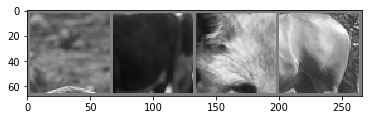

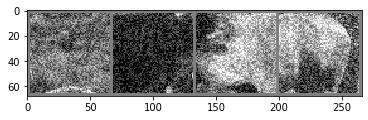

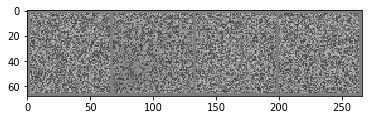

In [6]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(data_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
imshow(torchvision.utils.make_grid(labels))
imshow(torchvision.utils.make_grid(images-labels))

## check statistical property of noise images.

### on real noise dataset:

In [7]:
def print_mse_n_psnr(dataloader):
    
    mses = []
    psnrs = []
    for X, y in data_loader:
        Xs = X / 2 + 0.5     # unnormalize
        Xs = Xs.numpy()
        ys = y / 2 + 0.5     # unnormalize
        ys = ys.numpy()
        mse = np.mean((Xs-ys)**2)
        mses.append(mse)
        psnr = 10*np.log10(1/mse)
        psnrs.append(psnr)

    print("mse mean: {:.5f}, var: {:.4g}".format(np.mean(np.asarray(mses)), np.var(np.asarray(mses))))
    plt.hist(mses)
    plt.show()

    print("psnr mean: {:.3f}, var: {:.3f}".format(np.mean(np.asarray(psnrs)), np.var(np.asarray(psnrs))))
    plt.hist(psnrs)
    plt.show()

mse mean: 0.01930, var: 1.209e-06


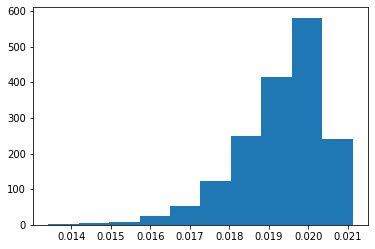

psnr mean: 17.152, var: 0.066


In [ ]:
print_mse_n_psnr(data_loader)